In [ ]:
rm -rf /content/Openpose

In [ ]:
!pip install g2o-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Step 1: Install unrar
!apt-get install unrar

# Step 2: Unzip the RAR file
import os

# Specify the path to your .rar file
rar_file_path = '/content/Output1.rar'

# Specify the directory where you want to extract the contents
extraction_path = '/content/Openpose'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the .rar file
!unrar x "{rar_file_path}" "{extraction_path}/"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Output1.rar

Creating    /content/Openpose/Output1                                 OK
Creating    /content/Openpose/Output1/p1                              OK
Creating    /content/Openpose/Output1/p1/p11                          OK
Extracting  /content/Openpose/Output1/p1/p11/p11_000000000000_keypoints.json       0%  OK 
Extracting  /content/Openpose/Output1/p1/p11/p11_000000000001_keypoints.json       0%  OK 
Extracting  /content/Openpose/Output1/p1/p11/p11_000000000002_keypoints.json       0%  OK 
Extracting  /content/Openpose/Output1/p1/p11/p11_000000000003_keypoints.json       0%  OK 
Extracting  /content/Openpose/Output1/p1/p11/p11_00000000

In [ ]:
import g2o
import json
import numpy as np
import os
from glob import glob
from pathlib import Path
from scipy.signal import savgol_filter

class PersonKeypointOptimizer:
    def __init__(self, person_folder):
        """Initialize optimizer for a specific person's sequences"""
        self.person_folder = person_folder
        self.sequences = {}
        self.reference_seq = None

        # Initialize g2o optimizer with basic settings
        self.optimizer = g2o.SparseOptimizer()
        linear_solver = g2o.LinearSolverEigenX()
        solver = g2o.BlockSolverX(linear_solver)
        algorithm = g2o.OptimizationAlgorithmLevenberg(solver)
        self.optimizer.set_algorithm(algorithm)

        # Define skeleton connections for anatomical constraints
        self.skeleton_connections = [
            (0, 1),   # Neck to nose
            (1, 2), (1, 5),  # Shoulders
            (2, 3), (3, 4),  # Right arm
            (5, 6), (6, 7),  # Left arm
            (1, 8), (8, 9), (9, 10),  # Right leg
            (1, 11), (11, 12), (12, 13)  # Left leg
        ]

        self.reference_bone_lengths = {}

    def interpolate_missing_keypoints(self, sequence):
        """Interpolate missing or low confidence keypoints"""
        interpolated_sequence = sequence.copy()

        # For each joint
        for joint_idx in range(sequence.shape[1]):
            # For each coordinate (x, y)
            for coord_idx in range(2):
                # Get the coordinate track
                coord_track = sequence[:, joint_idx, coord_idx]
                conf_track = sequence[:, joint_idx, 2]

                # Find frames with missing or low confidence keypoints
                missing_mask = np.isnan(coord_track) | (conf_track < 0.3)

                if np.any(missing_mask) and not np.all(missing_mask):
                    valid_frames = ~missing_mask
                    frame_indices = np.arange(len(coord_track))

                    # Interpolate missing values
                    interpolated_sequence[missing_mask, joint_idx, coord_idx] = np.interp(
                        frame_indices[missing_mask],
                        frame_indices[valid_frames],
                        coord_track[valid_frames]
                    )

                    # Set interpolated confidence to a lower value
                    interpolated_sequence[missing_mask, joint_idx, 2] = 0.3

        return interpolated_sequence

    def load_all_sequences(self):
        """Load all sequences for the person"""
        # Get person number (e.g., 'p1', 'p2', 'p3')
        person_name = os.path.basename(self.person_folder)

        # Find all sequence folders (e.g., p11, p12, p13)
        seq_pattern = os.path.join(self.person_folder, f"{person_name}[1-3]")
        seq_folders = sorted(glob(seq_pattern))

        if not seq_folders:
            raise ValueError(f"No sequence folders found in {self.person_folder}")

        for seq_folder in seq_folders:
            seq_name = os.path.basename(seq_folder)
            print(f"Loading sequence {seq_name}...")
            self.sequences[seq_name] = self.load_sequence(seq_folder)

            # First sequence (pX1) is reference
            if seq_name.endswith('1'):
                self.reference_seq = seq_name
                self.compute_reference_bone_lengths(self.sequences[seq_name])

    def load_sequence(self, seq_folder):
        """Load sequence with filtering"""
        json_pattern = os.path.join(seq_folder, '*_keypoints.json')
        json_files = sorted(glob(json_pattern))

        if not json_files:
            raise ValueError(f"No keypoint files found in {seq_folder}")

        sequence_data = []

        for json_file in json_files:
            try:
                with open(json_file, 'r') as f:
                    data = json.load(f)
                    if data['people'] and len(data['people']) > 0:
                        keypoints = np.array(data['people'][0]['pose_keypoints_2d'])
                        keypoints = keypoints.reshape(-1, 3)

                        # Filter low confidence keypoints
                        confidence_threshold = 0.3
                        low_conf_mask = keypoints[:, 2] < confidence_threshold
                        keypoints[low_conf_mask] = np.nan

                        sequence_data.append(keypoints)
                    else:
                        sequence_data.append(None)
            except Exception as e:
                print(f"Error loading {json_file}: {str(e)}")
                sequence_data.append(None)

        valid_sequence = np.array([kpts for kpts in sequence_data if kpts is not None])
        if len(valid_sequence) == 0:
            raise ValueError(f"No valid keypoints found in {seq_folder}")

        return self.interpolate_missing_keypoints(valid_sequence)

    def compute_reference_bone_lengths(self, sequence):
        """Compute average bone lengths from reference sequence"""
        self.reference_bone_lengths = {}
        for conn in self.skeleton_connections:
            lengths = []
            for frame in sequence:
                p1 = frame[conn[0]][:2]
                p2 = frame[conn[1]][:2]
                if not (np.isnan(p1).any() or np.isnan(p2).any()):
                    length = np.linalg.norm(p2 - p1)
                    lengths.append(length)
            if lengths:
                self.reference_bone_lengths[conn] = np.median(lengths)

    def create_keypoint_vertex(self, point_id, point):
        """Create a vertex for a keypoint"""
        v = g2o.VertexPointXY()
        v.set_id(point_id)
        v.set_estimate(point[:2])
        v.set_marginalized(False)

        if point[2] > 0.5:  # High confidence points are fixed
            v.set_fixed(True)
        return v

    def create_temporal_edge(self, vertex_id1, vertex_id2, measurement, information_matrix):
        """Create an edge between consecutive frames"""
        edge = g2o.EdgePointXY()
        edge.set_vertex(0, self.optimizer.vertex(vertex_id1))
        edge.set_vertex(1, self.optimizer.vertex(vertex_id2))
        edge.set_measurement(measurement)
        edge.set_information(information_matrix)
        edge.set_robust_kernel(g2o.RobustKernelHuber(0.1))  # Added scaling parameter
        return edge

    def optimize_sequence(self, seq_name):
        """Optimize a sequence using reference sequence as guide"""
        if seq_name == self.reference_seq:
            return self.sequences[seq_name]

        self.optimizer.clear()
        target_sequence = self.sequences[seq_name]
        reference_sequence = self.sequences[self.reference_seq]

        # Initialize vertices
        vertex_id = 0
        frame_vertices = []

        for frame_idx, frame_kpts in enumerate(target_sequence):
            frame_vs = []
            for kpt_idx in range(len(frame_kpts)):
                v = self.create_keypoint_vertex(vertex_id, frame_kpts[kpt_idx])
                self.optimizer.add_vertex(v)
                frame_vs.append(vertex_id)
                vertex_id += 1
            frame_vertices.append(frame_vs)

        # Add temporal edges with adaptive weights
        for i in range(len(frame_vertices) - 1):
            for j in range(len(frame_vertices[i])):
                v1_id = frame_vertices[i][j]
                v2_id = frame_vertices[i + 1][j]

                if i < len(reference_sequence) - 1:
                    movement = reference_sequence[i + 1][j][:2] - reference_sequence[i][j][:2]
                    confidence = min(reference_sequence[i][j][2], reference_sequence[i+1][j][2])
                    information = np.eye(2) * (1.0 + confidence)
                else:
                    movement = np.zeros(2)
                    information = np.eye(2)

                edge = self.create_temporal_edge(v1_id, v2_id, movement, information)
                self.optimizer.add_edge(edge)

        # Add skeleton constraints
        for conn in self.skeleton_connections:
            ref_length = self.reference_bone_lengths.get(conn)
            if ref_length is not None:
                for frame_vs in frame_vertices:
                    v1_id = frame_vs[conn[0]]
                    v2_id = frame_vs[conn[1]]
                    self.add_skeleton_constraint(v1_id, v2_id, ref_length)

        # Two-stage optimization
        print("Stage 1: Initial optimization...")
        self.optimizer.initialize_optimization()
        self.optimizer.optimize(10)

        print("Stage 2: Refinement...")
        self.optimizer.optimize(20)

        # Extract optimized keypoints
        optimized_sequence = []
        for frame_vs in frame_vertices:
            frame_kpts = []
            for v_id in frame_vs:
                vertex = self.optimizer.vertex(v_id)
                estimate = vertex.estimate()
                frame_kpts.append(np.array([estimate[0], estimate[1], 1.0]))
            optimized_sequence.append(np.array(frame_kpts))

        optimized_sequence = np.array(optimized_sequence)

        # Apply temporal smoothing
        smoothed_sequence = self.apply_temporal_smoothing(optimized_sequence)
        return smoothed_sequence

    def add_skeleton_constraint(self, v1_id, v2_id, target_length):
        """Add anatomical constraints between joints"""
        edge = g2o.EdgePointXY()
        edge.set_vertex(0, self.optimizer.vertex(v1_id))
        edge.set_vertex(1, self.optimizer.vertex(v2_id))

        v1_pos = self.optimizer.vertex(v1_id).estimate()
        v2_pos = self.optimizer.vertex(v2_id).estimate()
        current_length = np.linalg.norm(v2_pos - v1_pos)

        # Create a soft constraint to maintain bone length
        scale = target_length / current_length if current_length > 0 else 1.0
        target_pos = v1_pos + (v2_pos - v1_pos) * scale

        edge.set_measurement(target_pos - v1_pos)
        edge.set_information(np.eye(2) * 0.1)  # Soft constraint
        edge.set_robust_kernel(g2o.RobustKernelHuber(0.1))
        self.optimizer.add_edge(edge)

    def apply_temporal_smoothing(self, sequence, window_size=5):
        """Apply temporal smoothing to reduce jitter"""
        smoothed = sequence.copy()

        for joint_idx in range(sequence.shape[1]):
            for coord in range(2):  # Only smooth x and y coordinates
                joint_track = sequence[:, joint_idx, coord]
                smoothed[:, joint_idx, coord] = savgol_filter(
                    joint_track, window_size, 2, mode='nearest'
                )

        return smoothed

    def save_optimized_sequence(self, seq_name, optimized_sequence, output_folder):
        """Save optimized sequence to JSON files"""
        os.makedirs(output_folder, exist_ok=True)

        for i, keypoints in enumerate(optimized_sequence):
            output_data = {
                "version": 1.3,
                "people": [{
                    "pose_keypoints_2d": keypoints.flatten().tolist()
                }]
            }

            output_path = os.path.join(
                output_folder,
                f'{seq_name}_{i:012d}_keypoints.json'
            )
            with open(output_path, 'w') as f:
                json.dump(output_data, f)

            if i % 100 == 0:
                print(f"Saved frame {i} of {len(optimized_sequence)}")

def optimize_all_persons(base_path):
    """Optimize sequences for all persons"""
    person_pattern = os.path.join(base_path, "p[1-3]")
    person_folders = sorted(glob(person_pattern))

    if not person_folders:
        raise ValueError(f"No person folders found in {base_path}")

    for person_folder in person_folders:
        person_name = os.path.basename(person_folder)
        print(f"Processing {person_name}...")

        try:
            optimizer = PersonKeypointOptimizer(person_folder)
            optimizer.load_all_sequences()

            for seq_name in optimizer.sequences.keys():
                if seq_name != optimizer.reference_seq:
                    print(f"Optimizing {seq_name}...")
                    optimized_sequence = optimizer.optimize_sequence(seq_name)

                    output_folder = os.path.join(person_folder, f"{seq_name}_optimized")
                    optimizer.save_optimized_sequence(
                        seq_name,
                        optimized_sequence,
                        output_folder
                    )
                    print(f"Saved optimized sequence to {output_folder}")

        except Exception as e:
            print(f"Error processing {person_name}: {str(e)}")
            continue

In [ ]:
# Path to your Openpose folder
base_path = "/content/Openpose"

# Run optimization for all persons
optimize_all_persons(base_path)

Processing p1...
Loading sequence p11...
Loading sequence p12...
Loading sequence p13...
Optimizing p12...
Stage 1: Initial optimization...
Stage 2: Refinement...
Saved frame 0 of 240
Saved frame 100 of 240
Saved frame 200 of 240
Saved optimized sequence to /content/Openpose/p1/p12_optimized
Optimizing p13...
Stage 1: Initial optimization...
Stage 2: Refinement...
Saved frame 0 of 240
Saved frame 100 of 240
Saved frame 200 of 240
Saved optimized sequence to /content/Openpose/p1/p13_optimized
Processing p2...
Loading sequence p21...
Loading sequence p22...
Loading sequence p23...
Optimizing p22...
Stage 1: Initial optimization...
Stage 2: Refinement...
Saved frame 0 of 238
Saved frame 100 of 238
Saved frame 200 of 238
Saved optimized sequence to /content/Openpose/p2/p22_optimized
Optimizing p23...
Stage 1: Initial optimization...
Stage 2: Refinement...
Saved frame 0 of 239
Saved frame 100 of 239
Saved frame 200 of 239
Saved optimized sequence to /content/Openpose/p2/p23_optimized
Proces

In [ ]:
!pip install mediapipe opencv-python numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 34.7 MB/s eta 0:00:00


In [ ]:
import cv2
import json
import os
import numpy as np

class KeypointOverlay:
    def __init__(self, video_path, optimized_folder, output_video_path):
        # Corrected Body_25 connection pairs with minimal feet connections
        self.BODY_25_PAIRS = [
            # Head connections
            #(0, 1),  # Nose to Neck

            # Torso connections
            (1, 8),   # Neck to MidHip
            (1, 2),   # Neck to Right Shoulder
            (1, 5),   # Neck to Left Shoulder

            # Right arm connections
            (2, 3),   # Right Shoulder to Right Elbow
            (3, 4),   # Right Elbow to Right Wrist

            # Left arm connections
            (5, 6),   # Left Shoulder to Left Elbow
            (6, 7),   # Left Elbow to Left Wrist

            # Right leg connections
            (8, 9),   # MidHip to Right Hip
            (9, 10),  # Right Hip to Right Knee
            (10, 11), # Right Knee to Right Ankle

            # Left leg connections
            (8, 12),  # MidHip to Left Hip
            (12, 13), # Left Hip to Left Knee
            (13, 14), # Left Knee to Left Ankle

            # Additional head/body connections
            (0, 15),  # Nose to Right Eye
            (0, 16),  # Nose to Left Eye
            (15, 17), # Right Eye to Right Ear
            (16, 18), # Left Eye to Left Ear

            # Minimal feet connections
            (11, 22),  # Right Ankle to Right Big Toe
            (14, 21)  # Left Ankle to Left Big Toe
        ]

        # Video processing setup
        self.video_path = video_path
        self.optimized_folder = optimized_folder
        self.output_video_path = output_video_path

    def process_video(self):
        # Load the video
        cap = cv2.VideoCapture(self.video_path)
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Define the codec and create VideoWriter object
        out = cv2.VideoWriter(
            self.output_video_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            fps,
            (frame_width, frame_height)
        )

        # Get sorted JSON files
        json_files = sorted([f for f in os.listdir(self.optimized_folder) if f.endswith('.json')])

        try:
            for frame_idx in range(len(json_files)):
                ret, frame = cap.read()
                if not ret:
                    break

                # Load the keypoints from the JSON file
                json_path = os.path.join(self.optimized_folder, json_files[frame_idx])

                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    # Extract keypoints
                    if 'people' in data and len(data['people']) > 0:
                        # Reshape keypoints: x, y, confidence
                        keypoints = np.array(data['people'][0]['pose_keypoints_2d']).reshape(-1, 3)

                        # Confidence and visibility thresholds
                        CONFIDENCE_THRESHOLD = 0.5
                        MAX_CONNECTION_DISTANCE = max(frame_width, frame_height) * 0.5  # Increased to 50% of frame diagonal

                        # Draw keypoints with confidence scores
                        for i, (x, y, confidence) in enumerate(keypoints):
                            if confidence > CONFIDENCE_THRESHOLD and not (np.isnan(x) or np.isnan(y)):
                                # Draw keypoint circle
                                cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

                                # Choose text color based on confidence
                                text_color = (0, 0, 255) if confidence < 0.7 else (0, 255, 0)

                                # Put confidence text with larger font and more spacing
                                cv2.putText(
                                    frame,
                                    f"{confidence:.2f}",
                                    (int(x)+15, int(y)),
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    0.6,  # Increased font size
                                    text_color,
                                    1
                                )

                        # Draw connections
                        for (start, end) in self.BODY_25_PAIRS:
                            start_kp = keypoints[start]
                            end_kp = keypoints[end]

                            # Validate connection with more strict confidence check
                            if (start_kp[2] > CONFIDENCE_THRESHOLD and
                                end_kp[2] > CONFIDENCE_THRESHOLD):

                                # Calculate distance between points
                                distance = np.sqrt(
                                    (start_kp[0] - end_kp[0])**2 +
                                    (start_kp[1] - end_kp[1])**2
                                )

                                # Only draw if distance is reasonable
                                if distance < MAX_CONNECTION_DISTANCE:
                                    start_point = (int(start_kp[0]), int(start_kp[1]))
                                    end_point = (int(end_kp[0]), int(end_kp[1]))

                                    cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

                except Exception as e:
                    print(f"Error processing frame {frame_idx}: {e}")

                # Write the frame
                out.write(frame)

        finally:
            # Ensure resources are always released
            cap.release()
            out.release()

# Usage
def main():
    optimized_folder = "/content/Openpose/p3/p33_optimized"
    video_path = "/content/p33.MOV"
    output_video_path = "/content/G2O_Optimised_P33.MOV"

    overlay = KeypointOverlay(video_path, optimized_folder, output_video_path)
    overlay.process_video()

if __name__ == "__main__":
    main()

In [ ]:
import cv2
import json
import os
import numpy as np

class KeypointOverlay:
    def __init__(self, video_path, optimized_folder, output_video_path):
        # Corrected BODY_25 connection pairs with minimal feet connections
        self.BODY_25_PAIRS = [
            # Head connections
            (0, 1),  # Nose to Neck

            # Torso connections
            (1, 8),   # Neck to MidHip
            (1, 2),   # Neck to Right Shoulder
            (1, 5),   # Neck to Left Shoulder

            # Right arm connections
            (2, 3),   # Right Shoulder to Right Elbow
            (3, 4),   # Right Elbow to Right Wrist

            # Left arm connections
            (5, 6),   # Left Shoulder to Left Elbow
            (6, 7),   # Left Elbow to Left Wrist

            # Right leg connections
            (8, 9),   # MidHip to Right Hip
            (9, 10),  # Right Hip to Right Knee
            (10, 11), # Right Knee to Right Ankle

            # Left leg connections
            (8, 12),  # MidHip to Left Hip
            (12, 13), # Left Hip to Left Knee
            (13, 14), # Left Knee to Left Ankle

            # # Additional head/body connections
            # (0, 15),  # Nose to Right Eye
            # (0, 16),  # Nose to Left Eye
            # (15, 17), # Right Eye to Right Ear
            # (16, 18), # Left Eye to Left Ear

            # Minimal feet connections
            (11, 22),  # Right Ankle to Right Big Toe
            (14, 21)  # Left Ankle to Left Big Toe
        ]

        # Video processing setup
        self.video_path = video_path
        self.optimized_folder = optimized_folder
        self.output_video_path = output_video_path

    def process_video(self):
        # Load the video
        cap = cv2.VideoCapture(self.video_path)
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Define the codec and create VideoWriter object
        out = cv2.VideoWriter(
            self.output_video_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            fps,
            (frame_width, frame_height)
        )

        # Get sorted JSON files
        json_files = sorted([f for f in os.listdir(self.optimized_folder) if f.endswith('.json')])

        try:
            for frame_idx in range(len(json_files)):
                ret, frame = cap.read()
                if not ret:
                    break

                # Load the keypoints from the JSON file
                json_path = os.path.join(self.optimized_folder, json_files[frame_idx])

                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    # Extract keypoints
                    if 'people' in data and len(data['people']) > 0:
                        # Reshape keypoints: x, y, confidence
                        keypoints = np.array(data['people'][0]['pose_keypoints_2d']).reshape(-1, 3)

                        # Confidence and visibility thresholds
                        CONFIDENCE_THRESHOLD = 0.5
                        MAX_CONNECTION_DISTANCE = max(frame_width, frame_height) * 0.5  # Increased to 50% of frame diagonal

                        # Draw keypoints with confidence scores
                        for i, (x, y, confidence) in enumerate(keypoints):
                            if confidence > CONFIDENCE_THRESHOLD and not (np.isnan(x) or np.isnan(y)):
                                # Draw keypoint circle
                                cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

                        # Draw connections
                        for (start, end) in self.BODY_25_PAIRS:
                            start_kp = keypoints[start]
                            end_kp = keypoints[end]

                            # Validate connection with more strict confidence check
                            if (start_kp[2] > CONFIDENCE_THRESHOLD and
                                end_kp[2] > CONFIDENCE_THRESHOLD):

                                # Calculate distance between points
                                distance = np.sqrt(
                                    (start_kp[0] - end_kp[0])**2 +
                                    (start_kp[1] - end_kp[1])**2
                                )

                                # Only draw if distance is reasonable
                                if distance < MAX_CONNECTION_DISTANCE:
                                    start_point = (int(start_kp[0]), int(start_kp[1]))
                                    end_point = (int(end_kp[0]), int(end_kp[1]))

                                    cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

                except Exception as e:
                    print(f"Error processing frame {frame_idx}: {e}")

                # Write the frame
                out.write(frame)

        finally:
            # Ensure resources are always released
            cap.release()
            out.release()

# Usage
def main():
    optimized_folder = "/content/Openpose/p3/p33_optimized"
    video_path = "/content/p33.MOV"
    output_video_path = "/content/G2O_Optimised_P33.MOV"

    overlay = KeypointOverlay(video_path, optimized_folder, output_video_path)
    overlay.process_video()

if __name__ == "__main__":
    main()


In [ ]:
import cv2
import os
import glob

# Path to video files
video_directory = '/content/'
output_directory = '/content/frames/'

# List all .MOV files in the directory
video_files = glob.glob(video_directory + "*.MOV")

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

for video_path in video_files:
    # Extract the video name without extension
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Create a folder for each video to store its frames
    video_frames_dir = os.path.join(output_directory, video_name)
    os.makedirs(video_frames_dir, exist_ok=True)

    # Open the video file
    video_capture = cv2.VideoCapture(video_path)

    if not video_capture.isOpened():
        print(f"Error: Cannot open video file {video_path}. Skipping...")
        continue

    frame_count = 0
    success, frame = video_capture.read()

    while success:
        # Save each frame as a separate image file
        frame_filename = f"{video_frames_dir}/frame_{frame_count:04d}.jpg"
        cv2.imwrite(frame_filename, frame)

        # Read the next frame
        success, frame = video_capture.read()
        frame_count += 1

    video_capture.release()
    print(f"Frames for {video_name} have been extracted and saved to: {video_frames_dir}")

print("All videos processed!")


Frames for G2O_Optimised_P23 have been extracted and saved to: /content/frames/G2O_Optimised_P23
Frames for G2O_Optimised_P12 have been extracted and saved to: /content/frames/G2O_Optimised_P12
Frames for G2O_Optimised_P22 have been extracted and saved to: /content/frames/G2O_Optimised_P22
Frames for G2O_Optimised_P32 have been extracted and saved to: /content/frames/G2O_Optimised_P32
Frames for G2O_Optimised_P33 have been extracted and saved to: /content/frames/G2O_Optimised_P33
Frames for G2O_Optimised_P13 have been extracted and saved to: /content/frames/G2O_Optimised_P13
All videos processed!


In [ ]:
import shutil

# Path to the folder to be zipped
folder_to_zip = '/content/frames'
output_zip = '/content/frames.zip'

# Zip the folder
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)

print(f"Folder zipped successfully to {output_zip}")


Folder zipped successfully to /content/frames.zip



Processing folder: p11


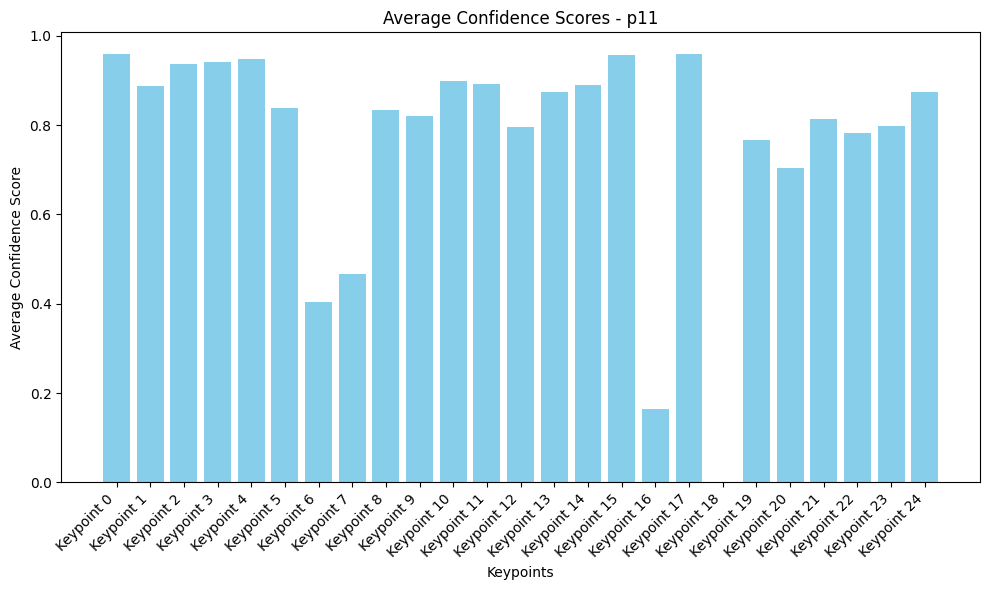


Processing folder: p12


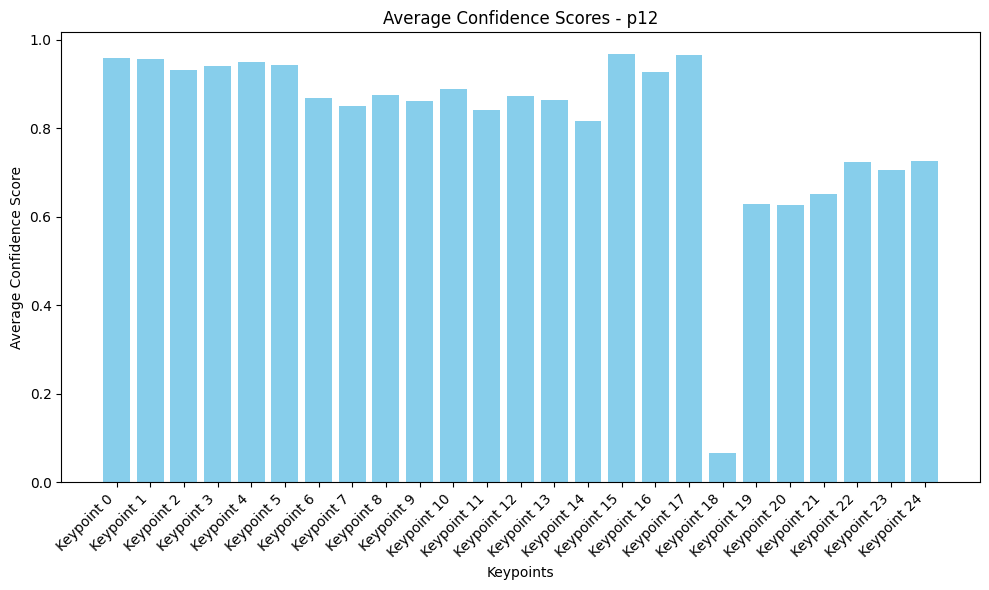


Processing folder: p13


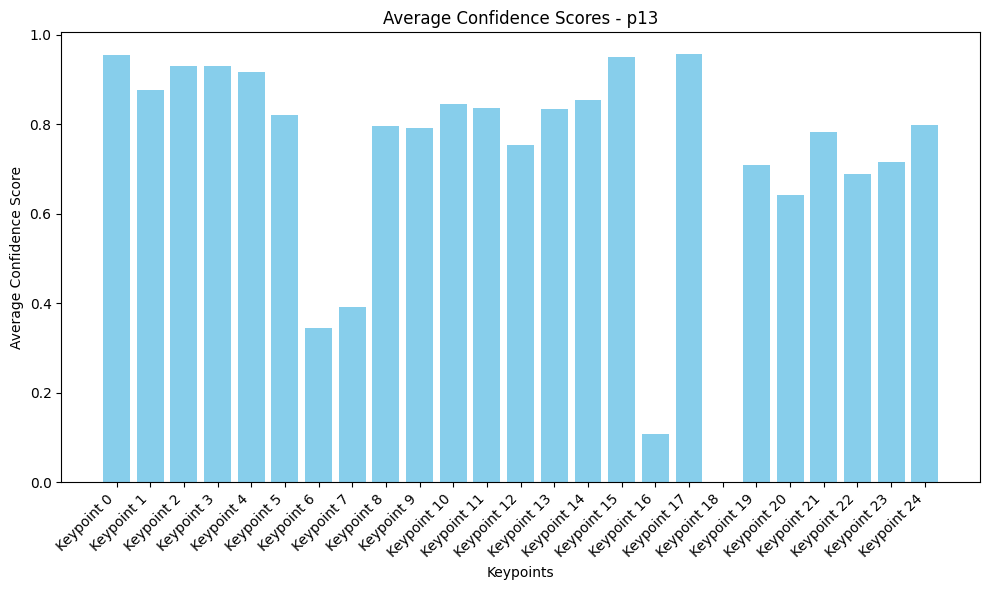

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Helper function to read confidence scores from a single JSON file
def extract_confidence_scores(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
        keypoints = data['people'][0]['pose_keypoints_2d'] if data['people'] else []
        # Confidence scores are every third value in the keypoints list
        confidence_scores = keypoints[2::3]
        return confidence_scores

# Helper function to calculate average confidence scores across all JSON files in a folder
def calculate_average_confidence(folder_path):
    all_confidences = []
    for file in os.listdir(folder_path):
        if file.endswith('_keypoints.json'):
            file_path = os.path.join(folder_path, file)
            scores = extract_confidence_scores(file_path)
            all_confidences.append(scores)

    # Convert to a numpy array and calculate average confidence for each keypoint
    if all_confidences:
        all_confidences = np.array(all_confidences)
        average_confidences = np.mean(all_confidences, axis=0)
        return average_confidences
    else:
        return []

# Function to plot average confidence scores for a given folder
def plot_average_confidence(folder_path, folder_name):
    average_confidences = calculate_average_confidence(folder_path)
    if len(average_confidences) > 0:
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(average_confidences)), average_confidences, color='skyblue')
        plt.xlabel('Keypoints')
        plt.ylabel('Average Confidence Score')
        plt.title(f'Average Confidence Scores - {folder_name}')
        plt.xticks(range(len(average_confidences)), [f'Keypoint {i}' for i in range(len(average_confidences))], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No JSON files with keypoints found in {folder_path}!")

# Process all subfolders in a parent folder
def process_all_subfolders(parent_folder):
    for subfolder in sorted(os.listdir(parent_folder)):
        subfolder_path = os.path.join(parent_folder, subfolder)
        if os.path.isdir(subfolder_path):  # Only process directories
            print(f"\nProcessing folder: {subfolder}")
            plot_average_confidence(subfolder_path, subfolder)

# Specify the parent folder (e.g., p1 in OpenPose structure)
parent_folder = '/content/Openpose/p1'

# Process and plot for all subfolders in the parent folder
process_all_subfolders(parent_folder)



Processing folder: /content/Openpose/p2/p21


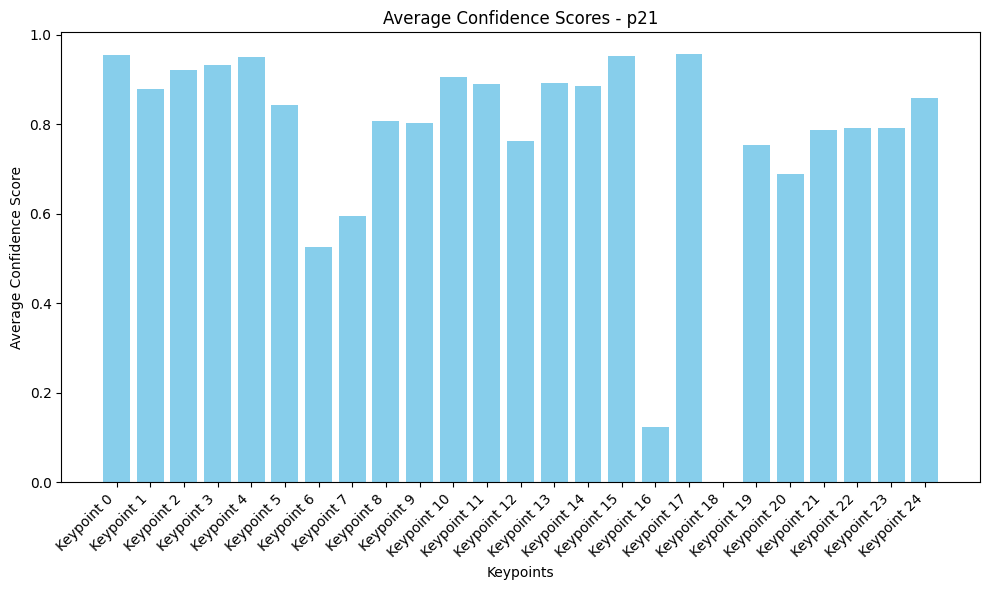


Processing folder: /content/Openpose/p2/p23


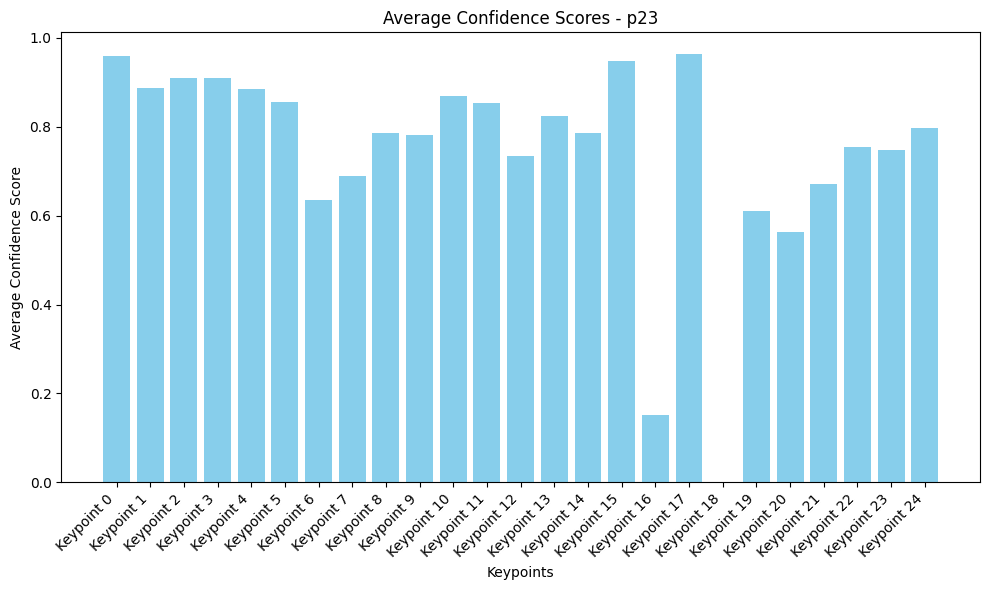


Processing folder: /content/Openpose/p2/p22_optimized


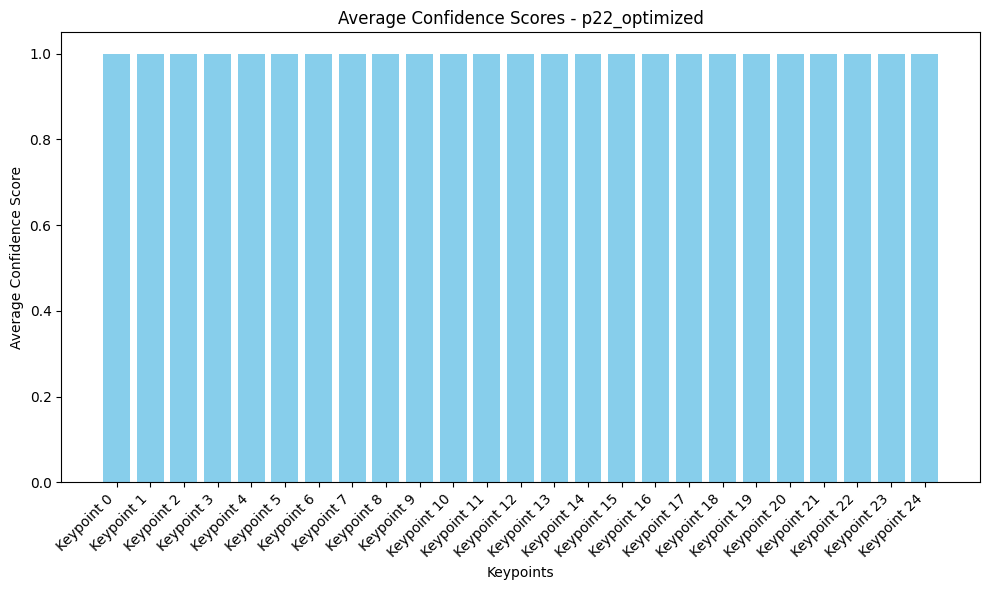


Processing folder: /content/Openpose/p2/p23_optimized


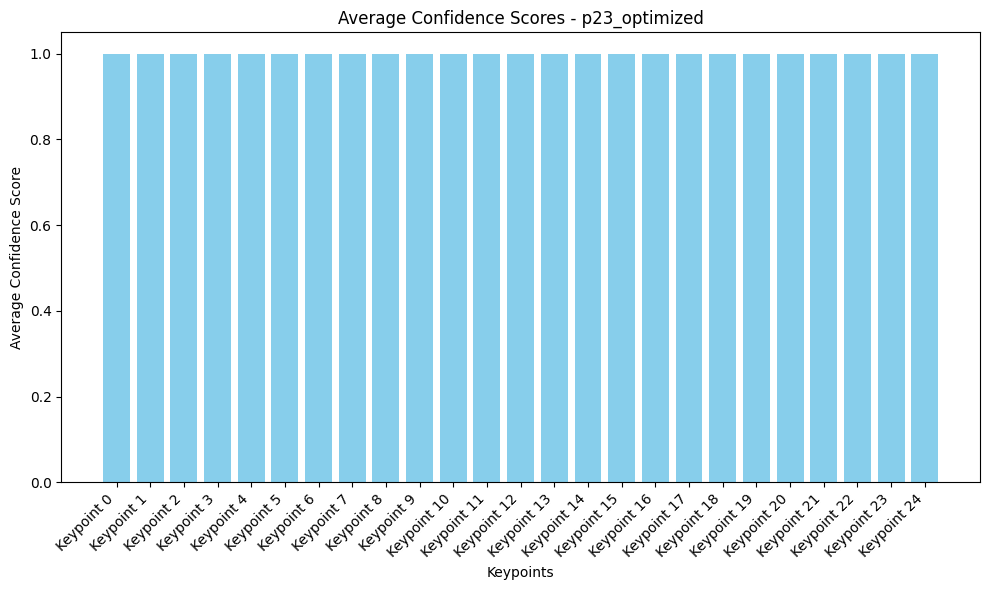


Processing folder: /content/Openpose/p2/p22


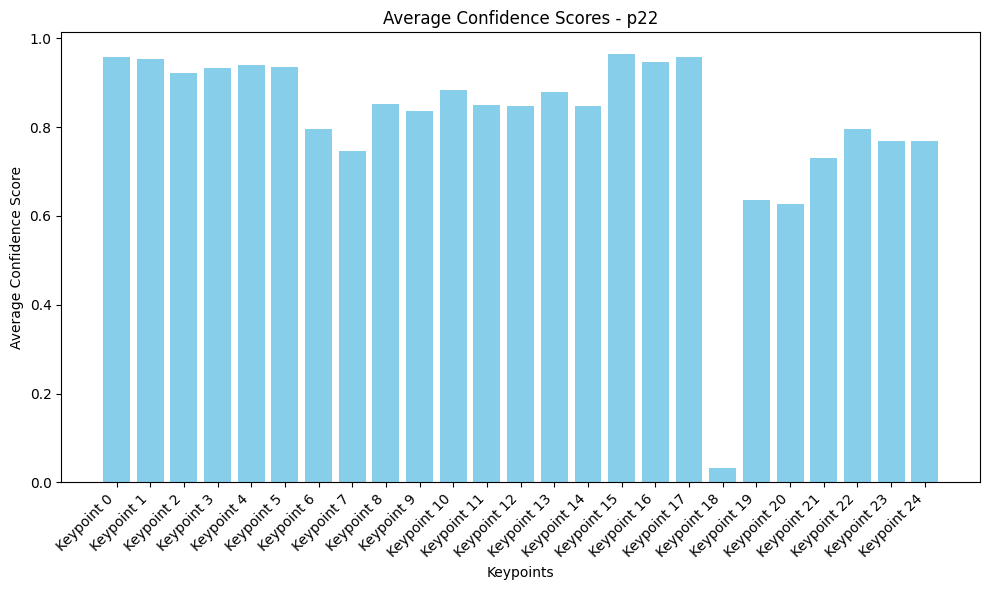


Processing folder: /content/Openpose/p1/p13_optimized


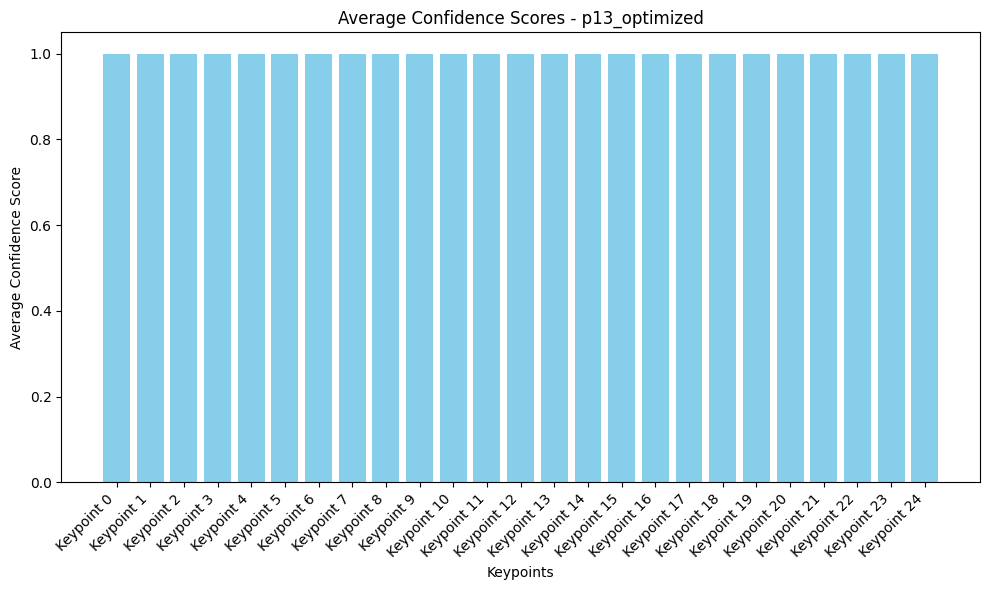


Processing folder: /content/Openpose/p1/p13


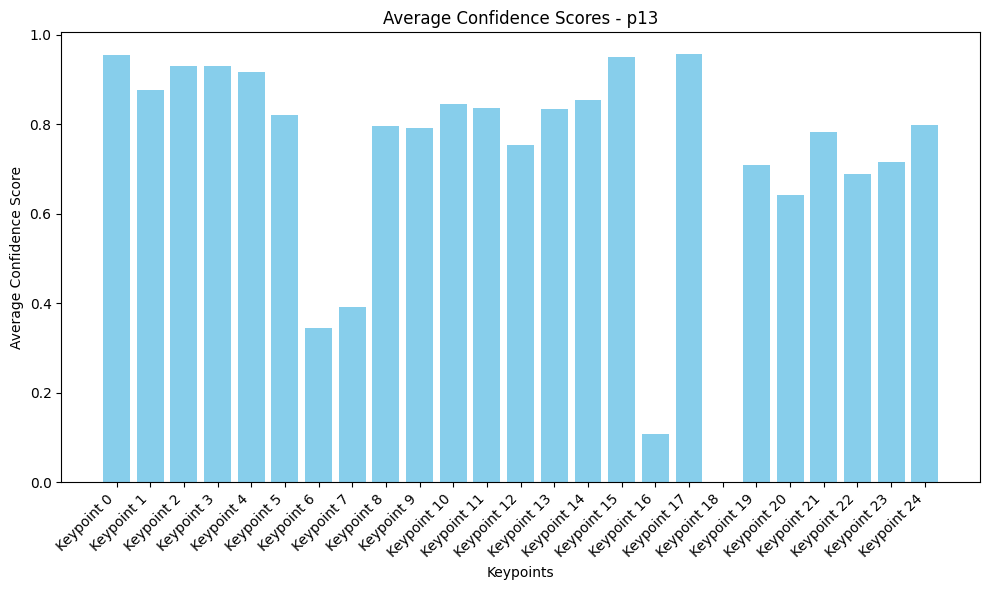


Processing folder: /content/Openpose/p1/p12


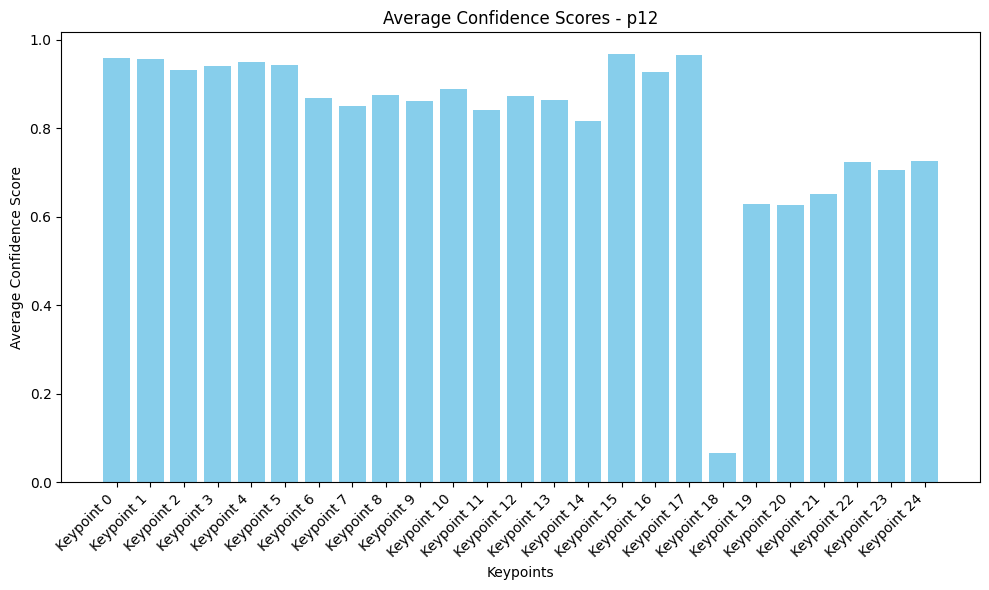


Processing folder: /content/Openpose/p1/p12_optimized


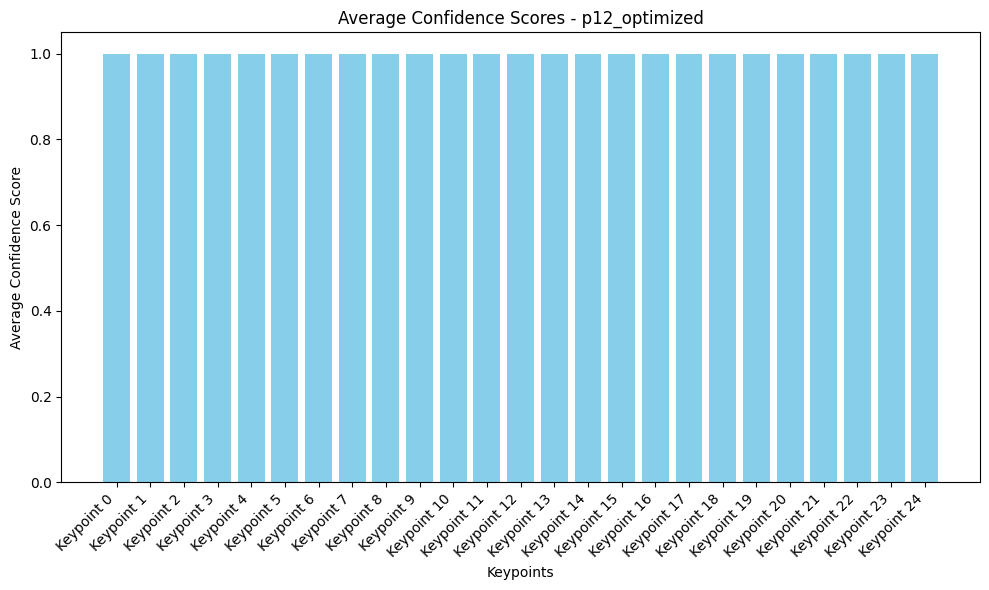


Processing folder: /content/Openpose/p1/p11


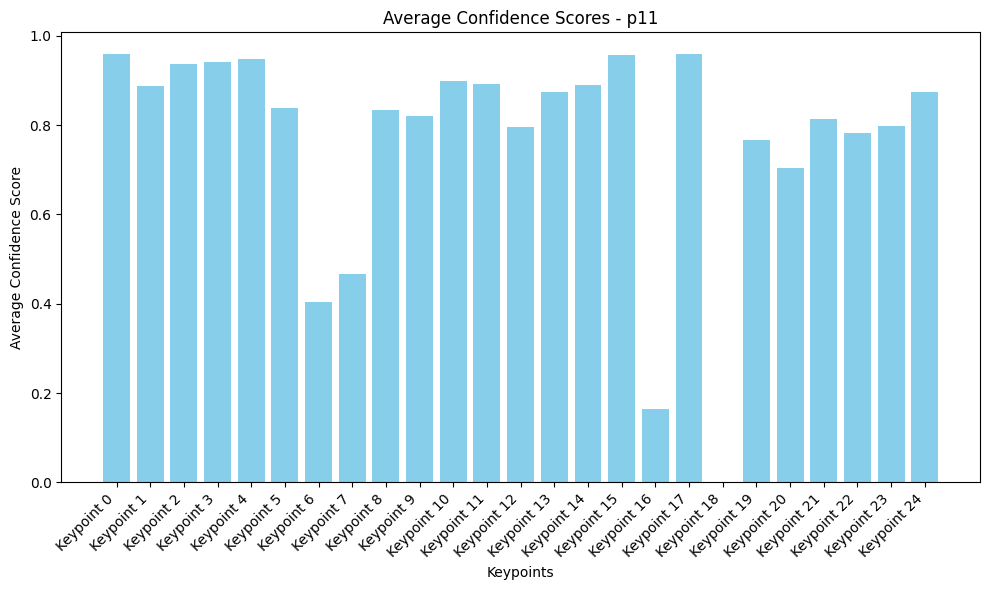


Processing folder: /content/Openpose/p3/p31


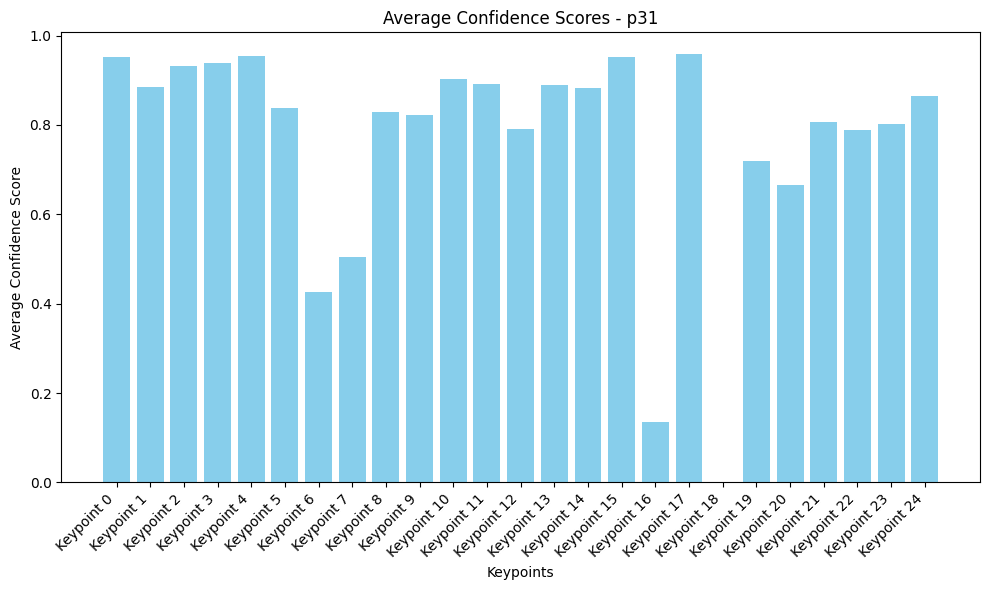


Processing folder: /content/Openpose/p3/p33_optimized


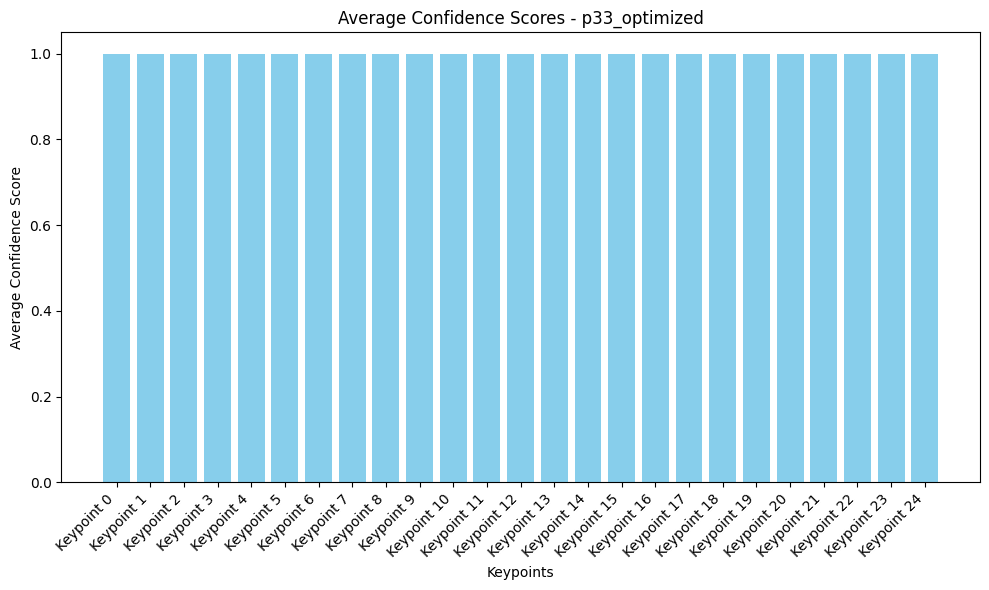


Processing folder: /content/Openpose/p3/p33


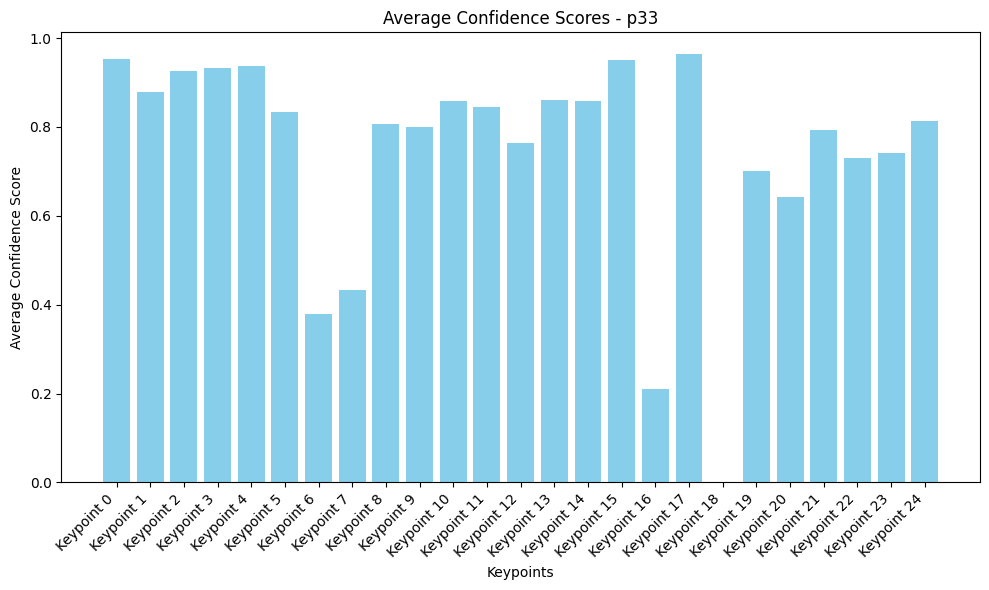


Processing folder: /content/Openpose/p3/p32


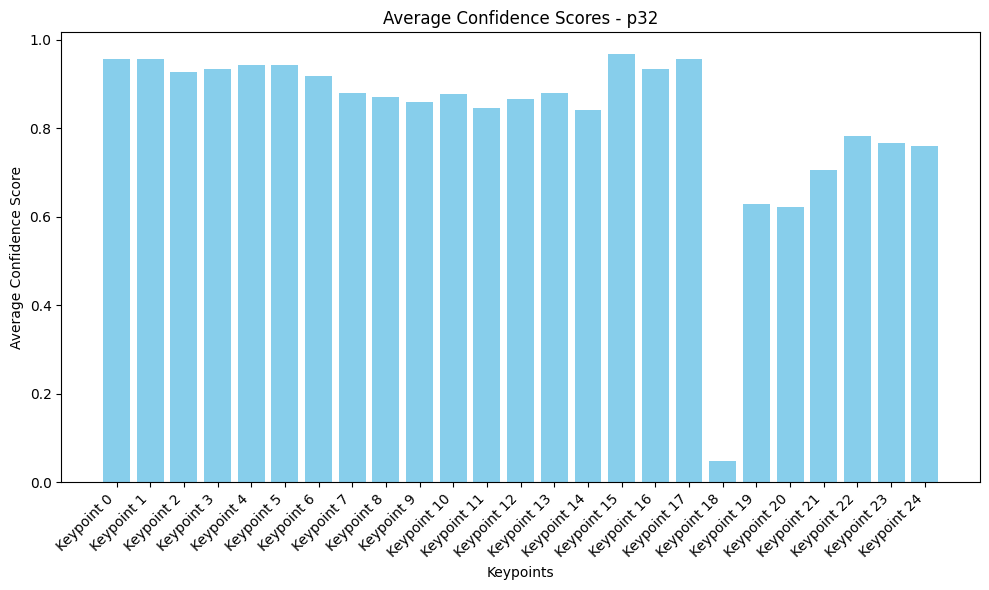


Processing folder: /content/Openpose/p3/p32_optimized


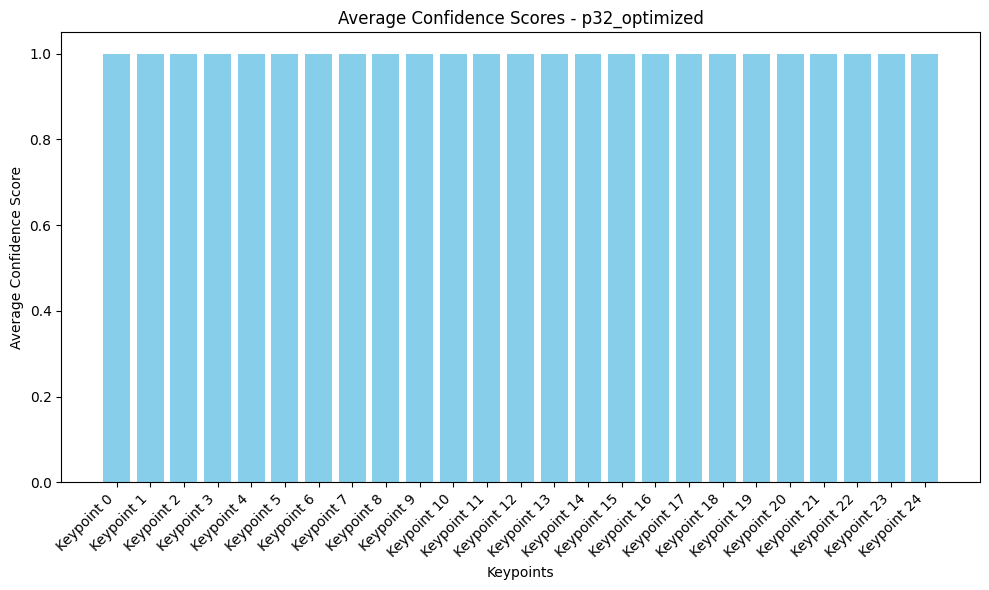

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Helper function to read confidence scores from a single JSON file
def extract_confidence_scores(json_path, keypoints_count=25):
    with open(json_path, 'r') as file:
        data = json.load(file)
        keypoints = data['people'][0]['pose_keypoints_2d'] if data['people'] else []
        # Confidence scores are every third value in the keypoints list
        confidence_scores = keypoints[2::3]

        # Handle missing keypoints by padding with 0
        while len(confidence_scores) < keypoints_count:
            confidence_scores.append(0)

        return confidence_scores[:keypoints_count]

# Helper function to calculate average confidence scores across all JSON files in a folder
def calculate_average_confidence(folder_path, keypoints_count=25):
    all_confidences = []
    for file in os.listdir(folder_path):
        if file.endswith('_keypoints.json'):
            file_path = os.path.join(folder_path, file)
            scores = extract_confidence_scores(file_path, keypoints_count)
            all_confidences.append(scores)

    # Convert to a numpy array and calculate average confidence for each keypoint
    if all_confidences:
        all_confidences = np.array(all_confidences)
        average_confidences = np.mean(all_confidences, axis=0)
        return average_confidences
    else:
        return []

# Function to plot average confidence scores for a given folder
def plot_average_confidence(folder_path, folder_name, keypoints_count=25):
    average_confidences = calculate_average_confidence(folder_path, keypoints_count)
    if len(average_confidences) > 0:
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(average_confidences)), average_confidences, color='skyblue')
        plt.xlabel('Keypoints')
        plt.ylabel('Average Confidence Score')
        plt.title(f'Average Confidence Scores - {folder_name}')
        plt.xticks(range(len(average_confidences)), [f'Keypoint {i}' for i in range(len(average_confidences))], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No JSON files with keypoints found in {folder_path}!")

# Recursively process all folders and subfolders
def process_all_folders_recursively(parent_folder, keypoints_count=25):
    for root, dirs, files in os.walk(parent_folder):
        if any(file.endswith('_keypoints.json') for file in files):
            folder_name = os.path.basename(root)
            print(f"\nProcessing folder: {root}")
            plot_average_confidence(root, folder_name, keypoints_count)

# Specify the root folder to start processing
root_folder = '/content/Openpose'

# Run the script on all folders under root
process_all_folders_recursively(root_folder)
